In [1]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter


# Real Gross Domestic Product (GDP) (Millions of chained 2012 dollars)																											

data_real_gdp = pd.read_excel("data/USA_RealGDP.xlsx", skiprows=5)
data_real_gdp = data_real_gdp.melt(["GeoFips", "GeoName"], var_name="Year", value_name="Real GDP")
data_real_gdp["GeoName"] = data_real_gdp["GeoName"].str.strip(" *")
data_real_gdp["Real GDP"] = pd.to_numeric(data_real_gdp["Real GDP"]) * 1_000_000
data_real_gdp.head()

/var/folders/gt/hp_y969x7hgchgtzlj0y7nhc0000gn/T/ipykernel_24546/2455770059.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/jiripesik/repositories/DKMEN/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,GeoFips,GeoName,Year,Real GDP
0,00000,United States,1997,1.152916e+13
1,01000,Alabama,1997,1.445012e+11
2,02000,Alaska,1997,4.221130e+10
3,04000,Arizona,1997,1.684088e+11
4,05000,Arkansas,1997,8.257130e+10


In [2]:
data_real_gdp.tail()

,GeoFips,GeoName,Year,Real GDP
1633,97000,Rocky Mountain,2022,7.493350e+11
1634,98000,Far West,2022,3.993762e+12
1635,Legend / Footnotes:,NaN,2022,NaN
1636,Real GDP is in millions of chained 2012 dollar...,NaN,2022,NaN
1637,"Last updated: March 31, 2023-- new statistics ...",NaN,2022,NaN


In [3]:
data_population = pd.read_excel("data/USA_Population.xlsx", skiprows=5)
data_population = data_population.melt(["GeoFips", "GeoName"], var_name="Year", value_name="Population")
data_population["GeoName"] = data_population["GeoName"].str.strip(" *")
data_population = data_population[data_population["Population"] != "(NA)"].reset_index(drop=True)
data_population["Population"] = pd.to_numeric(data_population["Population"])
data_population.head()

/Users/jiripesik/repositories/DKMEN/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,GeoFips,GeoName,Year,Population
0,00000,United States,1929,121769000.0
1,01000,Alabama,1929,2644000.0
2,04000,Arizona,1929,430000.0
3,05000,Arkansas,1929,1852000.0
4,06000,California,1929,5531000.0


In [4]:
data_abbr = pd.read_csv("data/StateAbbr.csv")
data_abbr = data_abbr[["state", "code"]]
data_abbr.head()

,state,code
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [5]:
data_merged = pd.merge(data_real_gdp, data_population, on=["GeoName", "GeoFips", "Year"])
data_merged = data_merged.merge(data_abbr, left_on="GeoName", right_on="state")
data_merged["Real GDP per capita"] = data_merged["Real GDP"] / data_merged["Population"]
data_merged["log GDP per capita"] = numpy.log(data_merged["Real GDP per capita"])
data_merged.head()

,GeoFips,GeoName,Year,Real GDP,Population,state,code,Real GDP per capita,log GDP per capita
0,01000,Alabama,1997,1.445012e+11,4367935.0,Alabama,AL,33082.268852,10.406753
1,02000,Alaska,1997,4.221130e+10,612968.0,Alaska,AK,68863.790606,11.139886
2,04000,Arizona,1997,1.684088e+11,4736990.0,Arizona,AZ,35551.858881,10.478748
3,05000,Arkansas,1997,8.257130e+10,2601090.0,Arkansas,AR,31744.883876,10.365487
4,06000,California,1997,1.378276e+12,32486010.0,California,CA,42426.770785,10.655535


In [6]:
data_merged.to_csv("USA_RealGDP.csv")

In [7]:
data_merged_sigma = data_merged.groupby("Year")["log GDP per capita"].std().to_frame()
data_merged_sigma["Region"] = "USA"
data_merged_sigma.to_csv("data/USA_sigma.csv")
data_merged_sigma

,log GDP per capita,Region
Year,,
1997,0.248182,USA
1998,0.246342,USA
1999,0.246761,USA
2000,0.245334,USA
2001,0.251470,USA
2002,0.247209,USA
2003,0.243702,USA
2004,0.245296,USA
2005,0.243477,USA


In [8]:
first_year = "2000"
last_year = "2022"

data_merged_growth = data_merged[data_merged["Year"].isin([first_year, last_year])].reset_index(drop=True)
data_merged_growth = data_merged_growth.sort_values(["GeoName", "Year"])
data_merged_growth[f"log GDP per capita {first_year}"] = data_merged_growth["log GDP per capita"].shift()
data_merged_growth[f"Real GDP per capita {first_year}"] = data_merged_growth["Real GDP per capita"].shift()
data_merged_growth = data_merged_growth[data_merged_growth["Year"] == last_year]
data_merged_growth["Ratio"] = data_merged_growth["log GDP per capita"] / data_merged_growth[f"log GDP per capita {first_year}"]
data_merged_growth = data_merged_growth.drop(columns=["GeoFips", "GeoName", "Population", "state", "Year"])
data_merged_growth = data_merged_growth.rename(columns={"code": "GeoName", "Real GDP per capita": f"Real GDP per capita {last_year}"})
data_merged_growth["Region"] = "USA"
data_merged_growth.head()

,Real GDP,GeoName,Real GDP per capita 2022,log GDP per capita,log GDP per capita 2000,Real GDP per capita 2000,Ratio,Region
51,2.132648e+11,AL,42028.450843,10.646102,10.472017,35313.385172,1.016624,USA
52,4.963370e+10,AK,67659.283271,11.122240,11.046963,62753.060292,1.006814,USA
53,3.564170e+11,AZ,48431.506861,10.787906,10.606354,40390.664936,1.017117,USA
54,1.265322e+11,AR,41545.397564,10.634542,10.420849,33551.893759,1.020506,USA
55,2.885627e+12,CA,73934.818066,11.210939,10.817878,49905.070843,1.036334,USA


In [9]:
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_reg = data_merged_growth.rename(columns={"Ratio": "y", f"log GDP per capita {first_year}": "x"})

formula = f"y ~ x"
mod = smf.ols(formula=formula, data=data_reg)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.992
Date:                Sun, 13 Oct 2024   Prob (F-statistic):              0.164
Time:                        10:30:03   Log-Likelihood:                 163.17
No. Observations:                  51   AIC:                            -322.3
Df Residuals:                      49   BIC:                            -318.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1072      0.062     17.784      0.000       0.982       1.232
x             -0.0082      0.006     -1.411      0.164      -0.020       0.003
==============================================================================
Omnibus:                        6.762   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                7.042
Skew:                           0.495   Prob(JB):                       0.0296
Kurtosis:                       4.527   Cond. No.                         478.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
influence = OLSInfluence(results)
data_reg['influence'] = influence.cooks_distance[0]
data_merged_growth["influence"] = data_reg["influence"]
data_merged_growth = data_merged_growth[data_merged_growth["influence"] < 1]
data_merged_growth.to_csv("data/USA.csv", index=False)

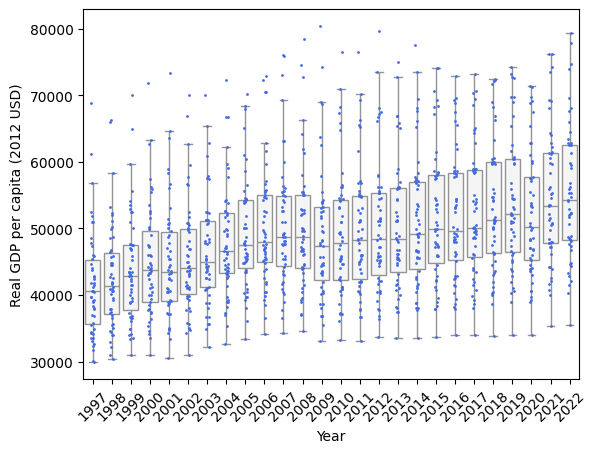

In [11]:
data_merged = data_merged[data_merged["code"] != "DC"]
sns.boxplot(
    data_merged, x="Year", y="Real GDP per capita", color="whitesmoke",  showfliers = False
)
ax = sns.stripplot(data_merged, x="Year", y="Real GDP per capita", size=2, color="royalblue")
ax.set_ylabel("Real GDP per capita (2012 USD)")
ax.tick_params(axis='x', rotation=45)
ax.figure.savefig("fig_output/Fig_02.png", dpi=600)

In [12]:
data_real_gdp_pivot = pd.pivot(data_merged, columns="Year", index="GeoName", values="Real GDP per capita")

def hp_filter(row):
    cycle, trend = hpfilter(row[1:], lamb=6.25)
    return trend

data_real_gdp_pivot = data_real_gdp_pivot.apply(hp_filter, axis=1)
data_real_gdp_pivot.to_csv("data/usa_filtered.csv")
data_real_gdp_pivot

Year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
GeoName,,,,,,,,,,,,,,,,,,,,,
Alabama,33966.555090,34536.369686,35104.574397,35738.151740,36537.493959,37502.294561,38515.505634,39326.616717,39760.043280,39803.167230,...,38977.962707,39051.819308,39194.738284,39418.553736,39701.232093,40018.366883,40357.388919,40745.127791,41256.630168,41804.038518
Alaska,65059.144637,64691.968190,64521.885449,64790.118828,65454.878712,66449.201897,67939.002205,69909.742625,72168.212123,74288.755489,...,76036.097358,75040.276148,74201.146520,73487.015508,72843.834944,72134.828218,71273.311545,70196.872978,69074.020159,67910.907469
Arizona,37959.230352,38984.662440,39934.493718,40823.822624,41740.734995,42709.077011,43617.876912,44319.093575,44601.603003,44351.375996,...,41490.027103,41816.559686,42340.646829,43048.744440,43886.512314,44763.742100,45629.164925,46496.401370,47441.840608,48393.380124
Arkansas,32346.132667,32950.933729,33532.615177,34172.674497,34955.693748,35836.119561,36671.600358,37278.543937,37525.623782,37414.108726,...,37159.250166,37428.717726,37671.861213,37913.352408,38202.227161,38576.435562,39052.258098,39659.916920,40419.170688,41229.041436
California,45358.076230,46830.613589,48169.638407,49267.991586,50296.183221,51394.980264,52561.087513,53692.100756,54600.458771,55112.732659,...,57107.036921,58546.596635,60263.807924,62154.373364,64151.813250,66148.857992,68075.081925,69976.636629,72049.335809,74096.211966
Colorado,49806.460530,50934.056641,51892.368328,52513.866384,52891.922938,53212.802879,53588.340122,54017.163447,54343.331484,54457.776154,...,54658.108490,55623.059039,56715.370276,57841.135375,59016.801160,60233.941246,61467.250889,62713.127601,64131.608315,65621.585702
Connecticut,58767.162401,60202.084356,61571.344828,62737.621658,63849.187053,65183.297997,66824.743648,68493.961996,69902.279821,70685.479821,...,66317.755151,66339.883381,66742.062317,67279.374687,67779.306621,68094.344519,68188.483652,68165.921531,68379.317019,68737.332702
Delaware,67977.272708,69466.995856,70651.713950,71309.101271,71418.588726,71287.795526,71017.743557,70511.190277,69876.601711,69173.707930,...,67836.808004,67730.371891,67243.387976,66250.515999,65181.262802,64442.062833,64054.248694,63849.213153,63868.235757,63981.019277
Florida,37942.233066,38911.427373,39884.507053,40885.831674,41966.291765,43097.460860,44151.045614,44900.344444,45120.823975,44719.255552,...,40921.867733,41357.299484,41991.979727,42710.241343,43446.370506,44168.613657,44890.323842,45686.833738,46686.382681,47748.961191
